In [266]:
from sklearn.model_selection import train_test_split, KFold
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import seaborn as sns
import itertools

In [77]:
df_data = pd.read_csv('../data/train.csv')
df_data.head()

,id,species,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,1,Acer_Opalus,0.007812,0.023438,0.023438,0.003906,0.011719,0.009766,0.027344,0.0,...,0.007812,0.000000,0.002930,0.002930,0.035156,0.0,0.0,0.004883,0.000000,0.025391
1,2,Pterocarya_Stenoptera,0.005859,0.000000,0.031250,0.015625,0.025391,0.001953,0.019531,0.0,...,0.000977,0.000000,0.000000,0.000977,0.023438,0.0,0.0,0.000977,0.039062,0.022461
2,3,Quercus_Hartwissiana,0.005859,0.009766,0.019531,0.007812,0.003906,0.005859,0.068359,0.0,...,0.154300,0.000000,0.005859,0.000977,0.007812,0.0,0.0,0.000000,0.020508,0.002930
3,5,Tilia_Tomentosa,0.000000,0.003906,0.023438,0.005859,0.021484,0.019531,0.023438,0.0,...,0.000000,0.000977,0.000000,0.000000,0.020508,0.0,0.0,0.017578,0.000000,0.047852
4,6,Quercus_Variabilis,0.005859,0.003906,0.048828,0.009766,0.013672,0.015625,0.005859,0.0,...,0.096680,0.000000,0.021484,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.031250


In [216]:
X = df_data.iloc[:,2:].values
species = df_data['species'].unique()

# Création des vecteurs one-hot pour la matrice de targets
t = np.zeros((len(X),species.size)) 
for i in range(species.size):
    t[df_data['species'] == species[i], i] = 1

In [217]:
device = torch.device('cpu')
if torch.backends.cuda.is_built():
    device = torch.device('cuda')

In [218]:
X_train, X_test, t_train, t_test = train_test_split(X, t, test_size=0.3, random_state=0)
X_train = torch.tensor(X_train, dtype=torch.float32, device=device)
X_test = torch.tensor(X_test, dtype=torch.float32, device=device)
t_train = torch.tensor(t_train, dtype=torch.float32, device=device)
t_test = torch.tensor(t_test, dtype=torch.float32, device=device)

In [239]:
def training_MLP(X_train, t_train, X_test, t_test, loss_function, optimizer, num_epochs=1, verbose=False):
    accuracy_train = []
    loss_train = []
    accuracy_test = []
    loss_test = []
    for epoch in range(num_epochs):
        accuracy = 0
        loss_epoch = 0
        for (x_sample, t_sample) in zip(X_train, t_train): # Dans une epoch nous parcourons toutes les données
            y = model(x_sample)
            loss = loss_function(y, t_sample)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_epoch += loss.item()
            accuracy += (torch.argmax(y) == torch.argmax(t_sample))
        accuracy = accuracy / X_train.shape[0]
        loss_train.append(loss_epoch / X_train.shape[0])
        accuracy_train.append(accuracy)
        
        y_test = model(X_test)
        loss = loss_function(y_test, t_test)
        loss_test.append(loss.item())
        accuracy_test.append(torch.sum(torch.eq(torch.argmax(y_test, dim=1), torch.argmax(t_test, dim=1))).item() / X_test.shape[0])
        if verbose:
            print("Epoch {}/{}, Loss: {:.5f}, Accuracy: {:.2f}%".format(epoch+1, num_epochs, loss_train[-1], accuracy_train[-1]*100))
        
        # Convergence de l'algorithme ça ne sert à rien de continuer à faire des calculs
        if len(loss_train) >= 2 and abs(loss_train[-1] - loss_train[-2]) <= 1e-4: 
            break
        
        # si nous avons une précision supérieure à 99% nous arrêtons l'entraînement car nous sommes en train de
        # faire du surapprentissage
        #if accuracy >= 0.99: 
         #   break
    return loss_train, accuracy_train, loss_test, accuracy_test

In [220]:
def plot_training(loss_train, accuracy_train, loss_test, accuracy_test):
    xdata = np.arange(1, len(loss_train) + 1)
    plt.figure()
    plt.subplot(2, 1, 1)
    plt.ylabel('Loss')
    plt.plot(xdata, loss_train, label='training')
    plt.plot(xdata, loss_test, label='validation')
    plt.xticks(xdata)
    plt.legend()
    
    plt.subplot(2, 1, 2)
    plt.ylabel('Accuracy')
    plt.plot(xdata, accuracy_train, label='training')
    plt.plot(xdata, accuracy_test, label='validation')
    plt.xticks(xdata)
    plt.legend()
    plt.show(block=False)

In [221]:
def reset_model_params(model):
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

## Création du model

In [240]:
# X.shape[1] : le nombre de caractéristiques
model = nn.Sequential(
    nn.Linear(X.shape[1], 96, bias=True, dtype=torch.float32), # couche d'entrée
    nn.ReLU(),
    nn.Linear(96, 96, bias=True, dtype=torch.float32), # couche cachée
    nn.ReLU(),
    nn.Linear(96, species.size, bias=True, dtype=torch.float32), # couche de sortie
)
model.to(device=device)

Sequential(
  (0): Linear(in_features=192, out_features=96, bias=True)
  (1): ReLU()
  (2): Linear(in_features=96, out_features=96, bias=True)
  (3): ReLU()
  (4): Linear(in_features=96, out_features=99, bias=True)
)

## Test d'entrainement via une descente de gradiant 

In [223]:
reset_model_params(model)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.5)
loss_train, accuracy_train, loss_test, accuracy_test = training_MLP(
    X_train, t_train, X_test, t_test,
    loss_function, optimizer, num_epochs=500, verbose=True)

Epoch 1/500, Loss: 4.60614, Accuracy: 0.87%
Epoch 2/500, Loss: 4.59823, Accuracy: 1.15%
Epoch 3/500, Loss: 4.59291, Accuracy: 1.15%
Epoch 4/500, Loss: 4.58914, Accuracy: 0.87%
Epoch 5/500, Loss: 4.58631, Accuracy: 1.30%
Epoch 6/500, Loss: 4.58410, Accuracy: 1.15%
Epoch 7/500, Loss: 4.58212, Accuracy: 1.30%
Epoch 8/500, Loss: 4.58025, Accuracy: 1.30%
Epoch 9/500, Loss: 4.57825, Accuracy: 1.30%
Epoch 10/500, Loss: 4.57596, Accuracy: 1.30%
Epoch 11/500, Loss: 4.57311, Accuracy: 0.87%
Epoch 12/500, Loss: 4.56921, Accuracy: 1.44%
Epoch 13/500, Loss: 4.56360, Accuracy: 1.88%
Epoch 14/500, Loss: 4.55482, Accuracy: 2.45%
Epoch 15/500, Loss: 4.54004, Accuracy: 3.17%
Epoch 16/500, Loss: 4.51388, Accuracy: 3.46%
Epoch 17/500, Loss: 4.46588, Accuracy: 3.46%
Epoch 18/500, Loss: 4.38307, Accuracy: 2.89%
Epoch 19/500, Loss: 4.27356, Accuracy: 2.89%
Epoch 20/500, Loss: 4.17189, Accuracy: 3.03%
Epoch 21/500, Loss: 4.09044, Accuracy: 3.61%
Epoch 22/500, Loss: 4.02021, Accuracy: 3.75%
Epoch 23/500, Loss:

In [224]:
print("Justesse du model de {:.2f}% sur les données test".format(accuracy_test[-1]*100))

Justesse du model de 76.43% sur les données test


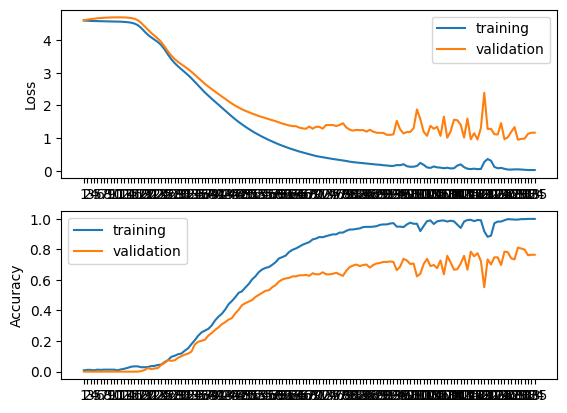

In [225]:
plot_training(loss_train, accuracy_train, loss_test, accuracy_test)

# Ajout d'un terme de régularisation

In [57]:
reset_model_params(model)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.5, weight_decay=1e-3)
loss_train, accuracy_train, loss_test, accuracy_test = training_MLP(
    X_train, t_train, X_test, t_test,
    loss_function, optimizer, num_epochs=500, verbose=True)

Epoch 1/500, Loss: 4.60513, Accuracy: 0.72%
Epoch 2/500, Loss: 4.59786, Accuracy: 0.43%
Epoch 3/500, Loss: 4.59293, Accuracy: 0.58%
Epoch 4/500, Loss: 4.58947, Accuracy: 0.87%
Epoch 5/500, Loss: 4.58698, Accuracy: 0.87%
Epoch 6/500, Loss: 4.58506, Accuracy: 1.01%
Epoch 7/500, Loss: 4.58354, Accuracy: 1.01%
Epoch 8/500, Loss: 4.58230, Accuracy: 1.01%
Epoch 9/500, Loss: 4.58117, Accuracy: 1.15%
Epoch 10/500, Loss: 4.58012, Accuracy: 1.15%
Epoch 11/500, Loss: 4.57904, Accuracy: 1.30%
Epoch 12/500, Loss: 4.57791, Accuracy: 1.15%
Epoch 13/500, Loss: 4.57663, Accuracy: 1.15%
Epoch 14/500, Loss: 4.57513, Accuracy: 1.15%
Epoch 15/500, Loss: 4.57326, Accuracy: 1.01%
Epoch 16/500, Loss: 4.57083, Accuracy: 0.87%
Epoch 17/500, Loss: 4.56747, Accuracy: 1.30%
Epoch 18/500, Loss: 4.56255, Accuracy: 2.31%
Epoch 19/500, Loss: 4.55499, Accuracy: 2.74%
Epoch 20/500, Loss: 4.54256, Accuracy: 3.17%
Epoch 21/500, Loss: 4.52084, Accuracy: 3.17%
Epoch 22/500, Loss: 4.48166, Accuracy: 3.32%
Epoch 23/500, Loss:

In [58]:
print("Justesse du model de {:.2f}% sur les données test".format(accuracy_test[-1]*100))

Justesse du model de 67.34% sur les données test


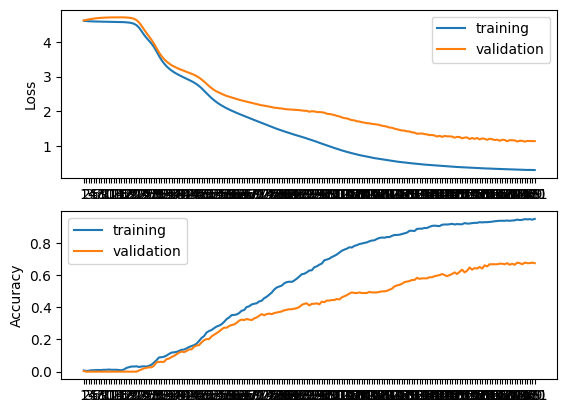

In [59]:
plot_training(loss_train, accuracy_train, loss_test, accuracy_test)

## Recherche des hyperparamètres

Nous réutilisons le code de la K-fold cross validation du TP4

In [91]:
lr_choices = [1e-3, 5e-2, 1e-2, 5e-1, 1e-1]
reg_choices = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10]
K = 5
kf = KFold(n_splits=K, shuffle=True)

best_accu = -1
best_params = None
accuracy_historic = np.zeros((len(lr_choices), len(reg_choices)))

for i, lr in enumerate(lr_choices):
    for j, reg in enumerate(reg_choices):
        print("testing parameters: learning_rate = {:.0e},    regularization = {:.0e}".format(lr, reg))
        params = (lr, reg)
        val_accu = 0
        
        for k, (k_train_indice, k_val_indice) in enumerate(kf.split(X_train)):
            reset_model_params(model)
            optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.5, weight_decay=reg)
            curves = training_MLP(
                X_train[k_train_indice], t_train[k_train_indice], X_train[k_val_indice], t_train[k_val_indice],
                loss_function, optimizer, num_epochs=2000)
            _, _, _, accuracy_validation = curves
            print('K = {}, accuracy: {:.3f}'.format(k, accuracy_validation[-1]))
            # Si nous avons une précision faible pour une itération de K cela ne sert à rien de calculer 
            # les autres itérations de K, nous pouvons déjà passer à une autre combinaison d'hyperparamètres.
            # Faire cela permet de réduire le temps de recherche de la meilleur combinaison d'hyperparamètres.
            if accuracy_validation[-1] <= 0.4: 
                val_accu = accuracy_validation[-1] * K
                break
            val_accu += accuracy_validation[-1]
        
        val_accu = val_accu / K
        accuracy_historic[i][j] = val_accu
        if val_accu > best_accu:
            print('Best val accuracy: {:.3f} | lr: {:.0e} | l2_reg: {:.0e}'.format(val_accu, lr, reg))
            best_accu = val_accu
            best_params = params

testing parameters: learning_rate = 1e-03,    regularization = 1e-02
K = 0, accuracy: 0.000
Best val accuracy: 0.000 | lr: 1e-03 | l2_reg: 1e-02
testing parameters: learning_rate = 1e-03,    regularization = 1e-03
K = 0, accuracy: 0.007
Best val accuracy: 0.007 | lr: 1e-03 | l2_reg: 1e-03
testing parameters: learning_rate = 1e-03,    regularization = 1e-04
K = 0, accuracy: 0.691
K = 1, accuracy: 0.763
K = 2, accuracy: 0.820
K = 3, accuracy: 0.754
K = 4, accuracy: 0.746
Best val accuracy: 0.755 | lr: 1e-03 | l2_reg: 1e-04
testing parameters: learning_rate = 1e-03,    regularization = 1e-05
K = 0, accuracy: 0.734
K = 1, accuracy: 0.770
K = 2, accuracy: 0.719
K = 3, accuracy: 0.761
K = 4, accuracy: 0.732
testing parameters: learning_rate = 1e-03,    regularization = 1e-06
K = 0, accuracy: 0.727
K = 1, accuracy: 0.755
K = 2, accuracy: 0.806
K = 3, accuracy: 0.616
K = 4, accuracy: 0.739
testing parameters: learning_rate = 1e-03,    regularization = 1e-07
K = 0, accuracy: 0.763
K = 1, accura

In [92]:
best_params

(0.05, 0.0001)

### Apprentissage complet du modèle avec les meilleurs hyperparamètres trouvés

In [94]:
reset_model_params(model)
optimizer = torch.optim.SGD(model.parameters(), lr=best_params[0], momentum=0.5, weight_decay=best_params[1])
loss_train, accuracy_train, loss_test, accuracy_test = training_MLP(
    X_train, t_train, X_test, t_test,
    loss_function, optimizer, num_epochs=2000, verbose=True)

Epoch 1/2000, Loss: 4.62995, Accuracy: 0.29%
Epoch 2/2000, Loss: 4.61825, Accuracy: 0.58%
Epoch 3/2000, Loss: 4.61517, Accuracy: 1.01%
Epoch 4/2000, Loss: 4.61225, Accuracy: 1.15%
Epoch 5/2000, Loss: 4.60775, Accuracy: 1.01%
Epoch 6/2000, Loss: 4.60237, Accuracy: 0.87%
Epoch 7/2000, Loss: 4.61437, Accuracy: 0.58%
Epoch 8/2000, Loss: 4.60834, Accuracy: 0.72%
Epoch 9/2000, Loss: 4.59510, Accuracy: 1.15%
Epoch 10/2000, Loss: 4.59203, Accuracy: 1.01%
Epoch 11/2000, Loss: 4.57860, Accuracy: 0.87%
Epoch 12/2000, Loss: 4.56841, Accuracy: 0.87%
Epoch 13/2000, Loss: 4.55933, Accuracy: 1.01%
Epoch 14/2000, Loss: 4.57284, Accuracy: 1.59%
Epoch 15/2000, Loss: 4.49837, Accuracy: 1.88%
Epoch 16/2000, Loss: 4.38565, Accuracy: 3.03%
Epoch 17/2000, Loss: 4.24582, Accuracy: 3.03%
Epoch 18/2000, Loss: 4.13450, Accuracy: 2.74%
Epoch 19/2000, Loss: 4.03538, Accuracy: 3.46%
Epoch 20/2000, Loss: 3.95332, Accuracy: 4.04%
Epoch 21/2000, Loss: 3.84949, Accuracy: 5.92%
Epoch 22/2000, Loss: 3.69303, Accuracy: 7.5

In [95]:
print("Justesse du model de {:.2f}% sur les données test".format(accuracy_test[-1]*100))

Justesse du model de 86.87% sur les données test


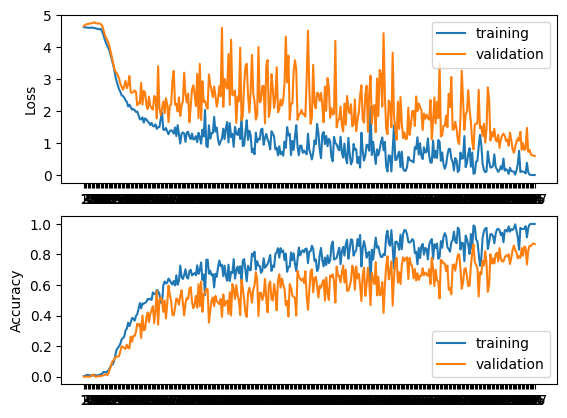

In [96]:
plot_training(loss_train, accuracy_train, loss_test, accuracy_test)

### Normalisation des données

In [235]:
df_data.iloc[:,2:].max()

margin1      0.087891
margin2      0.205080
margin3      0.156250
margin4      0.169920
margin5      0.111330
               ...   
texture60    0.578130
texture61    0.151370
texture62    0.375980
texture63    0.086914
texture64    0.141600
Length: 192, dtype: float64

Les données ne sont pas normalisées ce qui peut donner injustement plus de poids à certaines caractéristiques plutôt qu'à d'autre. Pour palier ce problème nous normalison nos données selon la normalisation min-max.

In [242]:
X = ((df_data.iloc[:,2:] - df_data.iloc[:,2:].min()) / (df_data.iloc[:,2:].max() - df_data.iloc[:,2:].min())).values

species = df_data['species'].unique()

# Création des vecteurs one-hot pour la matrice de targets
t = np.zeros((len(X),species.size)) 
for i in range(species.size):
    t[df_data['species'] == species[i], i] = 1
    
X_train, X_test, t_train, t_test = train_test_split(X, t, test_size=0.3, random_state=0)
X_train = torch.tensor(X_train, dtype=torch.float32, device=device)
X_test = torch.tensor(X_test, dtype=torch.float32, device=device)
t_train = torch.tensor(t_train, dtype=torch.float32, device=device)
t_test = torch.tensor(t_test, dtype=torch.float32, device=device)

In [243]:
reset_model_params(model)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.5, weight_decay=1e-4)
loss_train, accuracy_train, loss_test, accuracy_test = training_MLP(
    X_train, t_train, X_test, t_test,
    loss_function, optimizer, num_epochs=500, verbose=True)

Epoch 1/500, Loss: 4.59315, Accuracy: 1.59%
Epoch 2/500, Loss: 4.58850, Accuracy: 1.88%
Epoch 3/500, Loss: 4.58382, Accuracy: 1.73%
Epoch 4/500, Loss: 4.57898, Accuracy: 1.59%
Epoch 5/500, Loss: 4.57395, Accuracy: 1.44%
Epoch 6/500, Loss: 4.56853, Accuracy: 1.59%
Epoch 7/500, Loss: 4.56252, Accuracy: 1.44%
Epoch 8/500, Loss: 4.55560, Accuracy: 1.59%
Epoch 9/500, Loss: 4.54755, Accuracy: 1.59%
Epoch 10/500, Loss: 4.53808, Accuracy: 1.44%
Epoch 11/500, Loss: 4.52706, Accuracy: 1.59%
Epoch 12/500, Loss: 4.51422, Accuracy: 1.88%
Epoch 13/500, Loss: 4.49921, Accuracy: 2.16%
Epoch 14/500, Loss: 4.48177, Accuracy: 2.02%
Epoch 15/500, Loss: 4.46161, Accuracy: 2.45%
Epoch 16/500, Loss: 4.43862, Accuracy: 2.60%
Epoch 17/500, Loss: 4.41248, Accuracy: 2.89%
Epoch 18/500, Loss: 4.38274, Accuracy: 3.17%
Epoch 19/500, Loss: 4.34915, Accuracy: 3.17%
Epoch 20/500, Loss: 4.31114, Accuracy: 3.90%
Epoch 21/500, Loss: 4.26804, Accuracy: 4.33%
Epoch 22/500, Loss: 4.21887, Accuracy: 5.34%
Epoch 23/500, Loss:

In [244]:
print("Erreur du model de {:.4f} sur les données test".format(loss_test[-1]))
print("Précision du model de {:.2f}% sur les données test".format(accuracy_test[-1]*100))

Erreur du model de 0.3890 sur les données test
Précision du model de 93.27% sur les données test


Les performances du modèle sont grandement améliorées en normalisant les données.

In [253]:
lr_choices = [1e-4, 1e-3, 1e-2, 1e-1]
reg_choices = [1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9]
K = 5
kf = KFold(n_splits=K, shuffle=True)

best_accu = -1
best_params = None
accuracy_historic = np.zeros((len(lr_choices), len(reg_choices)))

for i, lr in enumerate(lr_choices):
    for j, reg in enumerate(reg_choices):
        print("testing parameters: learning_rate = {:.0e},    regularization = {:.0e}".format(lr, reg))
        params = (lr, reg)
        val_accu = 0
        
        for k, (k_train_indice, k_val_indice) in enumerate(kf.split(X_train)):
            reset_model_params(model)
            optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.5, weight_decay=reg)
            curves = training_MLP(
                X_train[k_train_indice], t_train[k_train_indice], X_train[k_val_indice], t_train[k_val_indice],
                loss_function, optimizer, num_epochs=1000)
            _, _, _, accuracy_validation = curves
            print('K = {}, accuracy: {:.3f}'.format(k, accuracy_validation[-1]))
            # Si nous avons une précision faible pour une itération de K cela ne sert à rien de calculer 
            # les autres itérations de K, nous pouvons déjà passer à une autre combinaison d'hyperparamètres.
            # Faire cela permet de réduire le temps de recherche de la meilleur combinaison d'hyperparamètres.
            val_accu += accuracy_validation[-1]
        
        val_accu = val_accu / K
        accuracy_historic[i][j] = val_accu
        if val_accu > best_accu:
            print('Best val accuracy: {:.3f} | lr: {:.0e} | l2_reg: {:.0e}'.format(val_accu, lr, reg))
            best_accu = val_accu
            best_params = params

testing parameters: learning_rate = 1e-04,    regularization = 1e-03
K = 0, accuracy: 0.885
K = 1, accuracy: 0.885
K = 2, accuracy: 0.878
K = 3, accuracy: 0.841
K = 4, accuracy: 0.855
Best val accuracy: 0.869 | lr: 1e-04 | l2_reg: 1e-03
testing parameters: learning_rate = 1e-04,    regularization = 1e-04
K = 0, accuracy: 0.842
K = 1, accuracy: 0.863
K = 2, accuracy: 0.906
K = 3, accuracy: 0.819
K = 4, accuracy: 0.877
testing parameters: learning_rate = 1e-04,    regularization = 1e-05
K = 0, accuracy: 0.899
K = 1, accuracy: 0.899
K = 2, accuracy: 0.863
K = 3, accuracy: 0.870
K = 4, accuracy: 0.862
Best val accuracy: 0.879 | lr: 1e-04 | l2_reg: 1e-05
testing parameters: learning_rate = 1e-04,    regularization = 1e-06
K = 0, accuracy: 0.878
K = 1, accuracy: 0.892
K = 2, accuracy: 0.871
K = 3, accuracy: 0.862
K = 4, accuracy: 0.841
testing parameters: learning_rate = 1e-04,    regularization = 1e-07
K = 0, accuracy: 0.835
K = 1, accuracy: 0.856
K = 2, accuracy: 0.885
K = 3, accuracy: 0.8

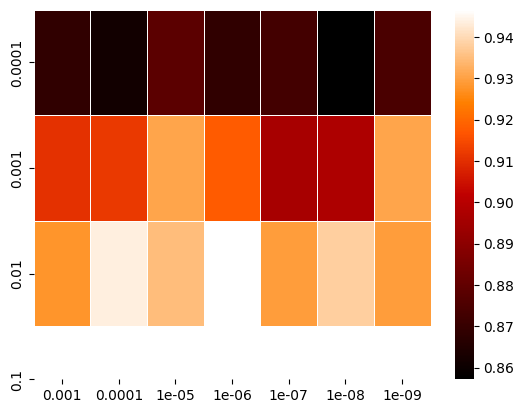

In [265]:
ax = sns.heatmap(accuracy_historic[:-1], linewidths=0.5, cmap='gist_heat', xticklabels=reg_choices, yticklabels=lr_choices)

In [267]:
best_params

(0.01, 1e-06)

### Apprentissage global avec les meilleurs hyperparamètres

In [268]:
reset_model_params(model)
optimizer = torch.optim.SGD(model.parameters(), lr=best_params[0], momentum=0.5, weight_decay=best_params[1])
loss_train, accuracy_train, loss_test, accuracy_test = training_MLP(
    X_train, t_train, X_test, t_test,
    loss_function, optimizer, num_epochs=2000, verbose=True)

Epoch 1/2000, Loss: 4.59843, Accuracy: 0.72%
Epoch 2/2000, Loss: 4.55102, Accuracy: 1.73%
Epoch 3/2000, Loss: 4.38826, Accuracy: 3.17%
Epoch 4/2000, Loss: 4.01776, Accuracy: 5.63%
Epoch 5/2000, Loss: 3.45574, Accuracy: 12.99%
Epoch 6/2000, Loss: 2.71888, Accuracy: 27.56%
Epoch 7/2000, Loss: 1.97486, Accuracy: 39.83%
Epoch 8/2000, Loss: 1.44279, Accuracy: 55.12%
Epoch 9/2000, Loss: 1.06288, Accuracy: 67.68%
Epoch 10/2000, Loss: 0.78283, Accuracy: 76.19%
Epoch 11/2000, Loss: 0.56733, Accuracy: 82.83%
Epoch 12/2000, Loss: 0.42427, Accuracy: 88.74%
Epoch 13/2000, Loss: 0.28360, Accuracy: 93.22%
Epoch 14/2000, Loss: 0.24505, Accuracy: 92.78%
Epoch 15/2000, Loss: 0.17099, Accuracy: 95.82%
Epoch 16/2000, Loss: 0.12338, Accuracy: 97.11%
Epoch 17/2000, Loss: 0.09500, Accuracy: 98.12%
Epoch 18/2000, Loss: 0.09799, Accuracy: 97.98%
Epoch 19/2000, Loss: 0.07119, Accuracy: 98.99%
Epoch 20/2000, Loss: 0.05143, Accuracy: 99.28%
Epoch 21/2000, Loss: 0.05702, Accuracy: 99.13%
Epoch 22/2000, Loss: 0.044

In [269]:
print("Justesse du model de {:.2f}% sur les données test".format(accuracy_test[-1]*100))

Justesse du model de 93.60% sur les données test


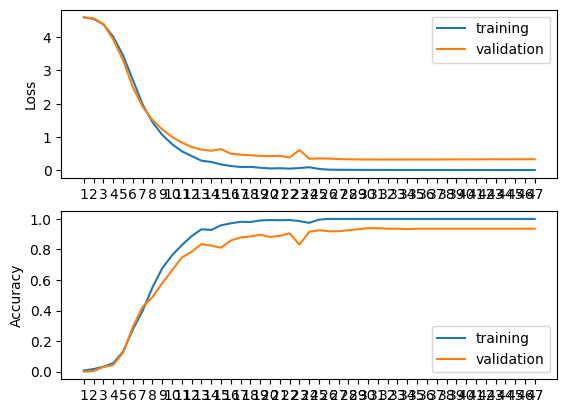

In [270]:
plot_training(loss_train, accuracy_train, loss_test, accuracy_test)